In [1]:
import sys
sys.path.insert(0, "../")

In [18]:
import numpy as np                                                         
import xarray as xr                                                        
                                                                           
import advtraj.utils as advtraj_utils                                      
from advtraj.interpolate import integrate_trajectories  

%matplotlib inline
                                                                           
def create_uniform_grid(dL, L):                                            
    Lx, Ly, Lz = L                                                         
    dx, dy, dz = dL                                                        
                                                                           
    x_ = np.arange(0, Lx, dx)                                              
    y_ = np.arange(0, Ly, dy)                                              
    z_ = np.arange(0, Lz, dz)                                              
                                                                           
    ds = xr.Dataset(coords=dict(x=x_, y=y_, z=z_))                         
    ds.x.attrs["units"] = "m"                                              
    ds.y.attrs["units"] = "m"                                              
    ds.z.attrs["units"] = "m"                                              
    ds.x.attrs["long_name"] = "x-horz. posn."                              
    ds.y.attrs["long_name"] = "y-horz. posn."                              
    ds.z.attrs["long_name"] = "height"                                     
                                                                           
    return ds                                                              
                                                                           
                                                                           
def create_initial_dataset(dL, L, xy_periodic=True):                       
    """                                                                    
    Create an initial dataset with a uniform grid and the position scalars 
    initiatied to the locations in the grid                                
    """                                                                    
    dx, dy, dz = dL                                                        
    ds_grid = create_uniform_grid(dL=dL, L=L)                              
                                                                           
    # make 3D arrays out of the 1D grid positions                          
    x, y, z = xr.broadcast(ds_grid.x, ds_grid.y, ds_grid.z)                
                                                                           
    i = x / dx                                                             
    j = y / dy                                                             
    k = z / dz                                                             
    nx = ds_grid.x.count()                                                 
    ny = ds_grid.y.count()                                                 
    nz = ds_grid.z.count()                                                 
                                                                           
    ds_position_scalars = advtraj_utils.grid_locations_to_position_scalars(
        i=i, j=j, k=k, nx=nx, ny=ny, nz=nz, xy_periodic=xy_periodic        
    )                                                                      
                                                                           
    ds = xr.merge([ds_grid, ds_position_scalars])                          
                                                                           
    ds["time"] = np.datetime64("2020-01-01T00:00")                         
    ds.attrs["xy_periodic"] = xy_periodic                                  
                                                                           
    return ds                                                              


In [9]:
def _advect_fields(ds_scalars, dx_grid, dy_grid, u, v, dt):
    """
    Perform poor-mans advection by rolling all variables in `ds_scalars` by a
    finite number of grid positions, requiring that the time-increment `dt`
    causes exactly grid-aligned shifts using grid resolution `dx_grid`,
    `dy_grid` with x- and y-velocity (`u`, `v`)
    """

    def _calc_shift(dx_, vel):
        n_shift = vel * dt / dx_
        if not np.isclose(n_shift, int(n_shift)):
            raise Exception(
                f"Advecting by time {dt} with velocity {vel} along grid with"
                f" spacing {dx_} does not result in a grid-aligned new position"
            )
        return int(n_shift)

    i_shift = _calc_shift(dx_grid, u)
    j_shift = _calc_shift(dy_grid, v)
    ds_new = ds_scalars.roll(dict(x=i_shift, y=j_shift), roll_coords=False)
    ds_new["time"] = ds_scalars.time + np.timedelta64(int(dt), "s")
    return ds_new



In [12]:
def _wrap_add(x, y, a, b):
    """add x+y modulu the answer being in range [a...b[
    https://stackoverflow.com/a/51467186/271776
    """
    y %= b - a
    x = x + y
    return x - (b - a) * (x >= b)



In [14]:
    
L = 5.0e3  # [m]
dx = 25.0  # [m]
dt = 25.0  # [s
u = 1.0  # [m/s]
v = 0.0  # [m/s]


Lx = Ly = L  # [m]
dy = dz = dx  # [m]

t_max = 600.0  # [s]
Lz = 1.0e3  # [m]

ds_initial = create_initial_dataset(dL=(dx, dy, dz), L=(Lx, Ly, Lz))

n_timesteps = int(t_max / dt)
datasets_timesteps = [ds_initial]
for n in range(n_timesteps):
    ds_new = _advect_fields(
        datasets_timesteps[-1], dx_grid=dx, dy_grid=dy, u=u, v=v, dt=dt
    )
    datasets_timesteps.append(ds_new)

ds = xr.concat(datasets_timesteps, dim="time")
# for now we just pick out the position scalars
position_scalars = [f"traj_tracer_{s}" for s in ["xr", "xi", "yr", "yi", "zr"]]
ds_position_scalars = ds[position_scalars]

# make up some starting points for the trajectories, making three trajectories for now
ds_starting_points = xr.Dataset()
ds_starting_points["x"] = 100.0
ds_starting_points.x.attrs["units"] = "m"
ds_starting_points["y"] = 200.0
ds_starting_points.y.attrs["units"] = "m"
ds_starting_points["z"] = Lz / 2.0
ds_starting_points.z.attrs["units"] = "m"
t0 = ds.time.isel(time=-1).values
ds_starting_points["time"] = ("trajectory_number"), [t0, t0, t0]

ds_starting_points = ds_starting_points.isel(trajectory_number=0)

ds_traj = integrate_trajectories(
    ds_position_scalars=ds_position_scalars, ds_starting_points=ds_starting_points
)

# work out how far the points should have moved
def _get_dt64_total_seconds(arr):
    return np.array(
        [dt64.astype("timedelta64[s]").item().total_seconds() for dt64 in arr]
    )

dt_steps = _get_dt64_total_seconds((t0 - ds.time).values)
x_steps = _wrap_add(ds_starting_points.x.item(), u * dt_steps, 0.0, Lx)
y_steps = _wrap_add(ds_starting_points.y.item(), v * dt_steps, 0.0, Ly)

assert np.all(x_steps == ds_traj.x.values)
assert np.all(y_steps == ds_traj.y.values)

backward:  96%|█████████▌| 24/25 [00:06<00:00,  4.03it/s]


AssertionError: 

In [23]:
ds_traj.x

<xarray.DataArray 'x' (time: 25)>
array([2600., 2625., 2675., 2750., 2850., 2975., 3125., 3300., 3500.,
       3725., 3975., 4250., 4550., 4875.,  225.,  600., 1000., 1425.,
       1875., 2350., 2850., 3375., 3925., 4500.,  100.])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-01T00:10:00
Attributes:
    units:      m
    long_name:  x-horz. posn.

In [15]:
x_steps

array([700., 675., 650., 625., 600., 575., 550., 525., 500., 475., 450.,
       425., 400., 375., 350., 325., 300., 275., 250., 225., 200., 175.,
       150., 125., 100.])

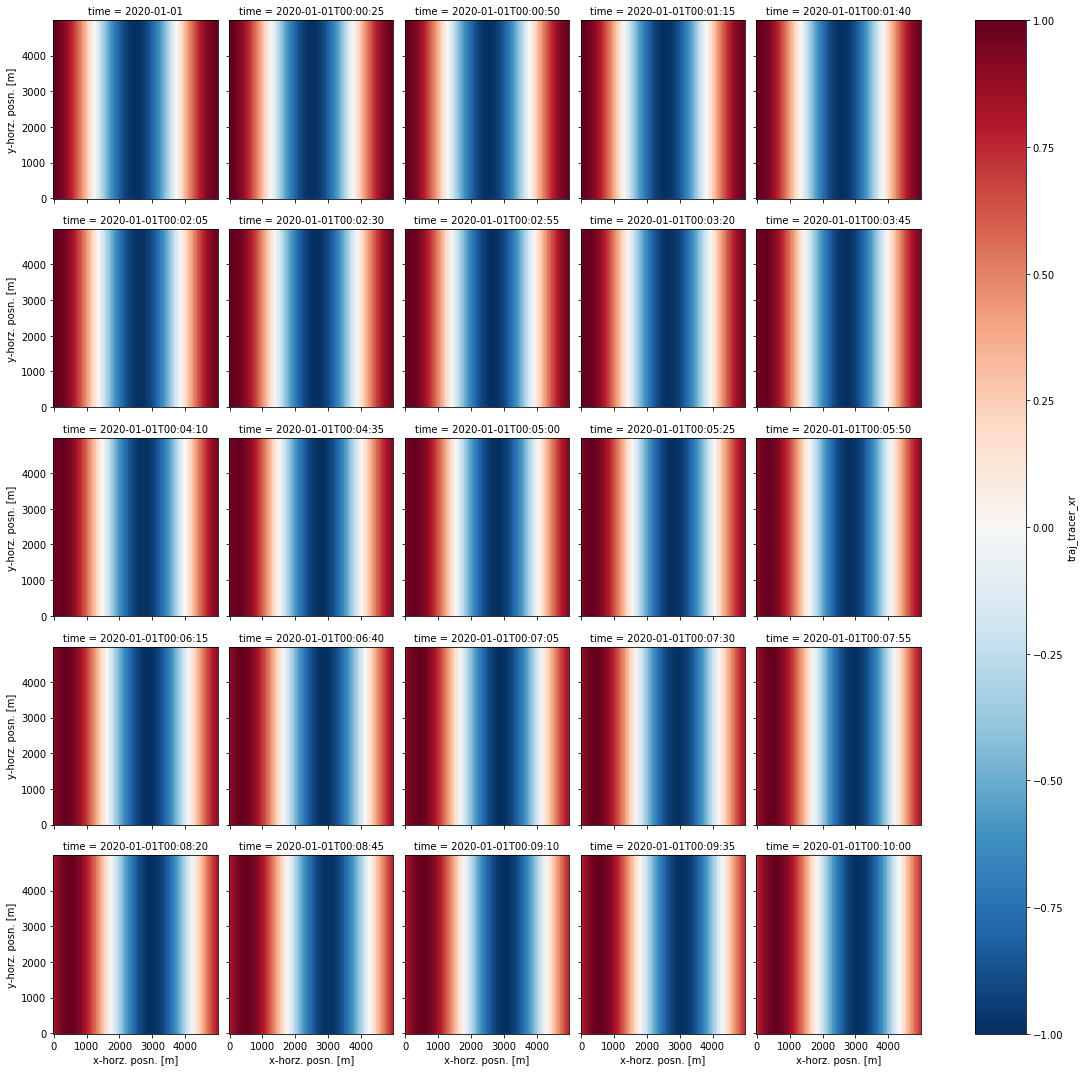

In [21]:
ds.traj_tracer_xr.isel(z=0).plot(y="y", col="time", col_wrap=5)

(0, 1000)

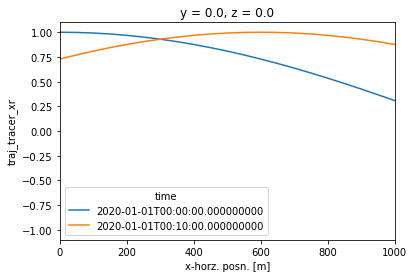

In [27]:
g = ds.traj_tracer_xr.isel(z=0, y=0).isel(time=[0,-1]).plot(hue="time")

g[0].axes.set_xlim(0, 1000)